In [ ]:
# Importing all relevant questions
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
import os, time, random
from PIL import Image
from skimage import io
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, MaxPooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomZoom, Rescaling
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

In [ ]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/chest_xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [ ]:
!rm -rf chest_xray/chest_xray/val/NORMAL/.DS_Store
!rm -rf chest_xray/chest_xray/train/NORMAL/.DS_Store
!rm -rf chest_xray/chest_xray/test/NORMAL/.DS_Store
!rm -rf chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
!rm -rf chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
!rm -rf chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [ ]:
# Specifying the paths to the training, validation, and testing locations
dir_path='chest_xray/chest_xray/'

train_path = dir_path+'train/'
valid_path = dir_path+'val/'
test_path = dir_path+'test/'

In [ ]:
### check number of train, valid and test images 
labels = ['NORMAL', 'PNEUMONIA']

def check_ims_in_folder(labels):
    '''returns tuples of images in each folder'''
    train_ims_normal = os.listdir(train_path+labels[0]+'/')
    train_ims_pneumonia = os.listdir(train_path+labels[1]+'/')
    
    valid_ims_normal = os.listdir(valid_path+labels[0]+'/')
    valid_ims_pneumonia = os.listdir(valid_path+labels[1]+'/')
    
    test_ims_normal = os.listdir(test_path+labels[0]+'/')
    test_ims_pneumonia = os.listdir(test_path+labels[1]+'/')
    
    return (train_ims_normal, train_ims_pneumonia), (valid_ims_normal, valid_ims_pneumonia), (test_ims_normal, test_ims_pneumonia)

[0.15 1.15 2.15 3.15 4.15 5.15]


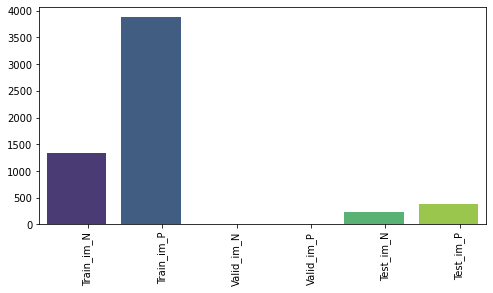

train_im_N:  1341
train_im_P:  3875
valid_im_N:  8
valid_im_P:  8
test_im_N:  234
test_im_P:  390


In [ ]:
# Splitting the labels into training, validation, and testing
(train_im_n, train_im_p), (valid_im_n, valid_im_p), (test_im_n, test_im_p) = check_ims_in_folder(labels)

# Plotting the number of occurences for each label
index = np.arange(6) + 0.15
print (index)
labels_bar = ['Train_im_N', 'Train_im_P', 'Valid_im_N', 'Valid_im_P', 'Test_im_N', 'Test_im_P']

# Plotting the bar chart for each label and folder
fig=plt.figure(figsize=(8, 4))
sns.barplot(x=index, y=[len(train_im_n), len(train_im_p), len(valid_im_n), len(valid_im_p), len(test_im_n), len(test_im_p)], palette="viridis")
plt.xticks(index, labels_bar, rotation='vertical')
plt.show()

# Printing out the corresponding count for every label
print ('train_im_N: ', len(train_im_n))
print ('train_im_P: ', len(train_im_p))
print ('valid_im_N: ', len(valid_im_n))
print ('valid_im_P: ', len(valid_im_p))
print ('test_im_N: ', len(test_im_n))
print ('test_im_P: ', len(test_im_p))


In [ ]:
# Counting the total number of images used for training + validation for normal and pneumonia
tot_normal_train = len(train_im_n) + len(valid_im_n) 
tot_pneumonia_train = len(train_im_p) + len(valid_im_p)
print ('total normal xray images: ', tot_normal_train)
print ('total pneumonia xray images: ', tot_pneumonia_train)


total normal xray images:  1349
total pneumonia xray images:  3883


In [ ]:
# Takes in the folder (training, validation, or testing) and the labels to return the images dimensions for every folder
def check_im_size(folder, labels):
    im_shape_x_lists_n = []
    im_shape_x_lists_p = []
    im_shape_y_lists_n = []
    im_shape_y_lists_p = []
    # Chooses the correct folder of data
    if folder=='val':
        path = valid_path
        normal = valid_im_n
        pneumonia = valid_im_p
    elif folder=='train':
        path = train_path
        normal = train_im_n
        pneumonia = train_im_p
    else:
        path = test_path
        normal = test_im_n
        pneumonia = test_im_p
    for i, img in enumerate(normal):
      # accesses the image
        sample = os.path.join(path+labels[0]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        # Adds the width and height
        im_shape_x_lists_n.append(w)
        im_shape_y_lists_n.append(h)
    for i, img in enumerate(pneumonia):
        sample = os.path.join(path+labels[1]+'/', img)
        sample_img = Image.open(sample)
        w, h = sample_img.size
        im_shape_x_lists_p.append(w)
        im_shape_y_lists_p.append(h)
        
    return im_shape_x_lists_n, im_shape_y_lists_n, im_shape_x_lists_p, im_shape_y_lists_p

In [ ]:
# Saving the shape for each folder
im_shape_valid_x_n, im_shape_valid_y_n, im_shape_valid_x_p, im_shape_valid_y_p = check_im_size('val', labels)
im_shape_train_x_n, im_shape_train_y_n, im_shape_train_x_p, im_shape_train_y_p = check_im_size('train', labels)
im_shape_test_x_n, im_shape_test_y_n, im_shape_test_x_p, im_shape_test_y_p = check_im_size('test', labels)  

{1632, 1272, 1288, 1736, 1776, 1328, 1240, 1564} {928, 1416, 1225, 1104, 1040, 1302}


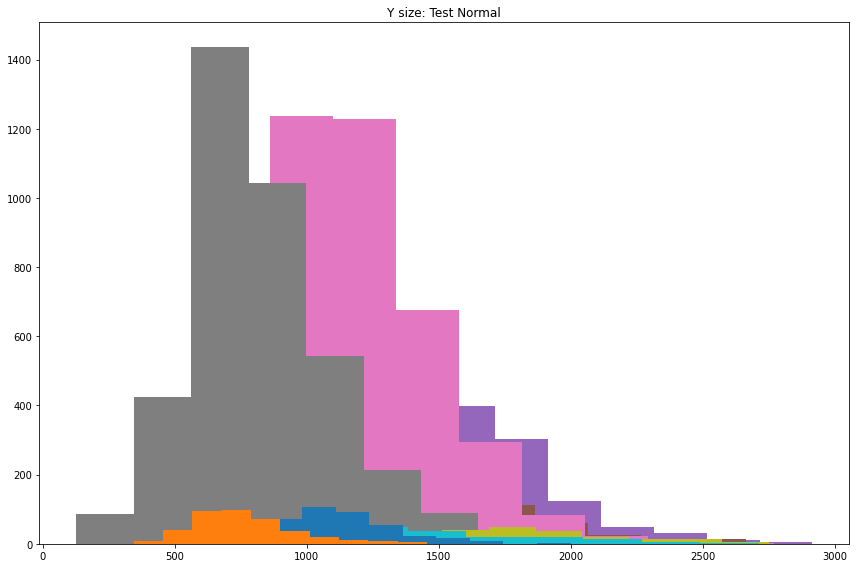

In [ ]:
ig = plt.figure(figsize=(12, 8))

# Plotting all the images from each folder and type of image in a histogram
fig.add_subplot(431)
plt.hist(im_shape_valid_x_n)
plt.title('X size: Valid Normal')
fig.add_subplot(432)
plt.hist(im_shape_valid_y_n)
plt.title('Y size: Valid Normal')
fig.add_subplot(433)
plt.hist(im_shape_valid_x_p)
plt.title('X size: Valid Pneumonia')
fig.add_subplot(434)
plt.hist(im_shape_valid_y_p)
plt.title('Y size: Valid Pneumonia')
fig.add_subplot(435)
plt.hist(im_shape_train_x_n)
plt.title('X size: Train Normal')
fig.add_subplot(436)
plt.hist(im_shape_train_y_n)
plt.title('Y size: Train Normal')
fig.add_subplot(437)
plt.hist(im_shape_train_x_p)
plt.title('X size: Train Pneumonia')
fig.add_subplot(438)
plt.hist(im_shape_train_y_p)
plt.title('Y size: Train Pneumonia')
fig.add_subplot(439)
plt.hist(im_shape_test_x_n)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 10)
plt.hist(im_shape_test_y_n)
plt.title('Y size: Test Normal')
fig.add_subplot(4,3, 11)
plt.hist(im_shape_test_x_p)
plt.title('X size: Test Normal')
fig.add_subplot(4,3, 12)
plt.hist(im_shape_test_y_p)
plt.title('Y size: Test Normal')
plt.tight_layout()
print (set(im_shape_valid_x_n), set(im_shape_valid_y_n))

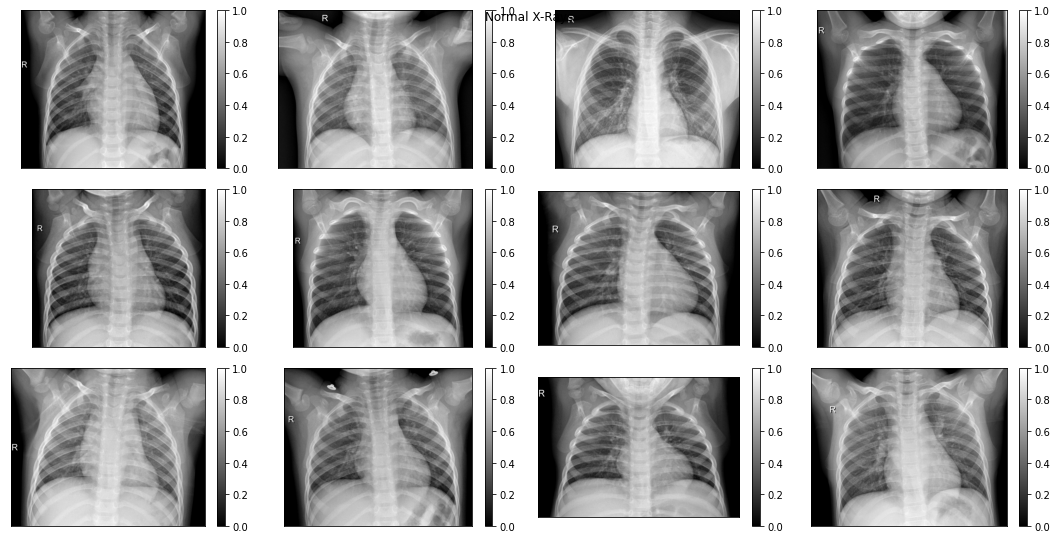

check shape of an example image:  (1746, 2164)


In [ ]:
fig = plt.figure(figsize=(15, 10))
npics= 12

count = 1
train_im_n_selected = random.sample(train_im_n, 12)
for i, img in enumerate(train_im_n_selected):
  # Processing the image from the dataset
    sample = os.path.join(train_path +labels[0]+'/', img) 
    sample_img = Image.open(sample)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0

    # Plotting
    ax = fig.add_subplot(int(npics/3) , 4, count, xticks=[],yticks=[])
    plt.imshow(sample_img, cmap='gray')
    plt.colorbar()
    count +=1
fig.suptitle('Normal X-Rays')
plt.tight_layout()
plt.show()

print ('check shape of an example image: ', sample_img.shape,)


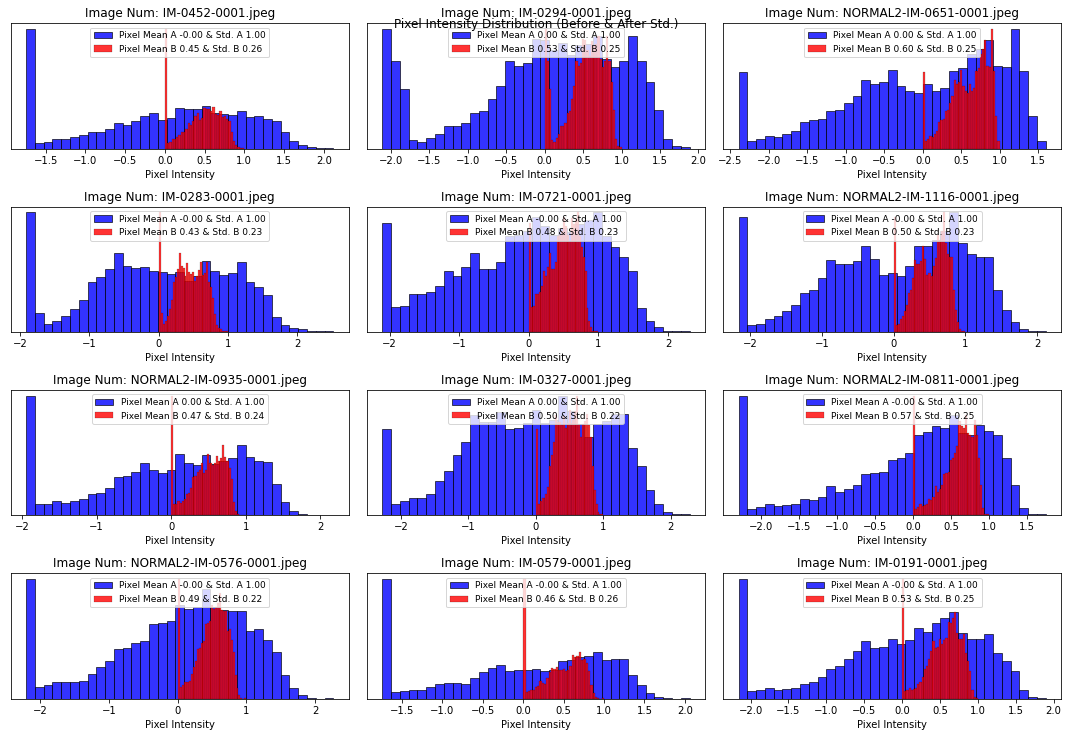

In [ ]:
fig = plt.figure(figsize=(15, 15))
count=1
for i, img in enumerate(train_im_n_selected):
  # Processing the image from the dataset
    sample_one = os.path.join(train_path +labels[0]+'/', img)
    sample_img = Image.open(sample_one)   
    sample_img = np.array(sample_img)
    sample_img = sample_img/255.0
    sample_img_mean = np.mean(sample_img)
    sample_img_std = np.std(sample_img)
    new_sample_img = (sample_img - sample_img_mean)/sample_img_std

    # Plotting
    ax = fig.add_subplot(int(npics/2) , 3, count, yticks=[])
    sns.histplot(new_sample_img.ravel(), 
             label=f'Pixel Mean A {np.mean(new_sample_img):.2f} & Std. A {np.std(new_sample_img):.2f}', kde=False, color='blue', bins=35, alpha=0.8)
    sns.histplot(sample_img.ravel(), 
             label=f'Pixel Mean B {np.mean(sample_img):.2f} & Std. B {np.std(sample_img):.2f}', kde=False, color='red', bins=35, alpha=0.8)
    plt.legend(loc='upper center', fontsize=9)
    plt.title('Image Num: %s'% (img))
    plt.xlabel('Pixel Intensity')
    plt.ylabel('# Pixels in Image')
    count +=1
fig.suptitle('Pixel Intensity Distribution (Before & After Std.)')
plt.tight_layout()
plt.show()

In [ ]:
#### define a function that will be added as lambda layer later
### calculates mean and standard deviation of a column, then subtracts the mean from each sample point, then divides it by the standard deviation
def standardize_layer(tensor):
    tensor_mean = tf.math.reduce_mean(tensor)
    tensor_std = tf.math.reduce_std(tensor)
    new_tensor = (tensor-tensor_mean)/tensor_std
    return new_tensor

In [ ]:
#image dimensions were different so we condense everything into 300 by 300 pixels
target_size = (300, 300)

# Input shape for the image is a 300 by 300 square with depth 1
input_shape = (300, 300, 1)

batch_size = 64


print("Training Dataset.....")
train_dir = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/chest_xray//train/', 
                                                                image_size=target_size, 
                                                                batch_size=batch_size,
                                                                shuffle=True,
                                                                color_mode='grayscale',
                                                                label_mode='binary')



print("Val Dataset....")
val_dir = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/chest_xray//val/', 
                                                              image_size=target_size, 
                                                              batch_size=batch_size,
                                                              color_mode='grayscale',
                                                              label_mode='binary')

print("Test Datast...")
test_dir = tf.keras.preprocessing.image_dataset_from_directory('chest_xray/chest_xray/test/', 
                                                               image_size=target_size, 
                                                               batch_size=batch_size, 
                                                               color_mode='grayscale',
                                                               label_mode='binary')

Training Dataset.....
Found 5216 files belonging to 2 classes.
Val Dataset....
Found 16 files belonging to 2 classes.
Test Datast...
Found 624 files belonging to 2 classes.


In [ ]:
# Number of batches
num_elements = tf.data.experimental.cardinality(train_dir).numpy()
print (num_elements)
# Validation elements
num_elements_val = tf.data.experimental.cardinality(val_dir).numpy()
print (num_elements_val)


82
1


In [ ]:
# Returning the class names in the training set
class_names = train_dir.class_names
print(class_names)


['NORMAL', 'PNEUMONIA']


In [ ]:
# Combining the original training and validation into a new training set
new_train_ds = train_dir.concatenate(val_dir)

print (new_train_ds, train_dir)

train_size = int(0.8 * 83) # 83 is the elements in dataset (train + valid)
val_size = int(0.2 * 83)
    
train_ds = new_train_ds.take(train_size)
val_ds = new_train_ds.skip(train_size).take(val_size)


#### check the dataset size back again 
num_elements_train = tf.data.experimental.cardinality(train_ds).numpy()
print (num_elements_train)
num_elements_val_ds = tf.data.experimental.cardinality(val_ds).numpy()
print (num_elements_val_ds)

<ConcatenateDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))> <BatchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
66
16


In [ ]:
## This cell was used to compile the baseline model
### Cosine Decay was tested

class customCallbacks(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.epoch = epoch + 1
    if self.epoch % 2 == 0:
      print (
          'epoch num {}, train loss: {}, validation loss: {}'.format(epoch, logs['loss'], logs['val_loss']))

reduce_lr = ReduceLROnPlateau(monitor='val_loss',  factor=0.2, patience=3, min_lr=1e-8, verbose=1)



# mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
#                            save_best_only=True, save_weights_only=True, monitor='val_loss')



## added after saving the best model  via val loss gives worse performance than the final step of the model 

mcp_save = ModelCheckpoint(filepath="best_model_weights.h5",
                           save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min')



##restore best weights added after 2nd training
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


### added after 2nd training 

METRICS = ['accuracy', 
           tf.keras.metrics.Precision(name='precision'), 
           tf.keras.metrics.Recall(name='recall'), 
           tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
          ]

In [ ]:
freq_neg = tot_normal_train/(tot_normal_train + tot_pneumonia_train)
freq_pos = tot_pneumonia_train/(tot_normal_train + tot_pneumonia_train)

pos_weights = np.array([freq_neg])
neg_weights = np.array([freq_pos])

print ('check positive weight: ', pos_weights, len(pos_weights))
print ('check negative weight: ', neg_weights)


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    """
    Return weighted loss function given negative weights and positive weights.

    Args:
      pos_weights (np.array): array of positive weights for each class, size (num_classes)
      neg_weights (np.array): array of negative weights for each class, size (num_classes)
    
    Returns:
      weighted_loss (function): weighted loss function
    """
    def weighted_loss(y_true, y_pred):
        """
        Return weighted loss value. 

        Args:
            y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
            y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
        Returns:
            loss (float): overall scalar loss summed across all classes
        """
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)): # we have only 1 class 
            # for each class, add average weighted loss for that class 
            loss += - (K.mean((pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon)) + 
                              (neg_weights[i] * (1-y_true[:, i]) * K.log(1-y_pred[:, i] + epsilon)) ) )
        return loss
    return weighted_loss

check positive weight:  [0.25783639] 1
check negative weight:  [0.74216361]


In [ ]:
# Downloading inception v3 
input_shape = (300, 300, 3)

# Reading in the data
inception_resnet_v2 = InceptionResNetV2(
    include_top=False,
   # weights="../input/inceptionresnetv2/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5",
    input_shape=input_shape)

In [ ]:
# Creating a rescale_layer - scaling everything by dividing all pixels by 255
from tensorflow.keras import layers

rescale_layer = tf.keras.Sequential([layers.experimental.preprocessing.Rescaling(1./255)])

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip(),
  layers.experimental.preprocessing.RandomRotation(10), 
  layers.experimental.preprocessing.RandomZoom(0.1)
])



In [ ]:
# Creating the model, adding inception_v3 first then adding layers on top of that
def build_model():
    inputs = Input((300, 300, 1))
    
    x = preprocess_input(inputs) # necessary as per keras documentation 
    x = layers.Lambda(rescale_layer)(x) # rescale incoming images
    x = layers.Lambda(standardize_layer)(x) # standardize incoming images
    x = layers.Lambda(data_augmentation)(x) # data augmentation layers
    x = Conv2D(3, (3,3), padding='same')(x) 
    # this is to fool the network that instead of rgb image we passed grayscale image but still have shape 3 at last axis (none, x, x, 3). 
    
    
    
    ###### InceptionResNetV2 + Some Top Layers
    x = BatchNormalization()(x)
    x = inception_resnet_v2(x)

    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(256, (1, 1), activation=LeakyReLU())(x)
    x = BatchNormalization()(x)
    
    x = Flatten()(x)
    x = Dropout(0.75)(x)

    x = Dense(256, activation=LeakyReLU())(x)
    x = Dropout(0.80)(x)
    x = BatchNormalization()(x)
    
    outputs = Dense(1, activation="sigmoid")(x)
    
    model = Model(inputs, outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                 loss=get_weighted_loss(pos_weights, neg_weights), 
                 metrics=METRICS)
     
    return model

In [ ]:
model = build_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 1)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 300, 300, 1)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 300, 300, 1)      0         
 a)                                                              
                                                                 
 lambda (Lambda)             (None, 300, 300, 1)       0         
                                                                 
 lambda_1 (Lambda)           (None, 300, 300, 1)       0         
                                                                 
 lambda_2 (Lambda)           (None, 300, 300, 1)       0     

In [ ]:
autotune = tf.data.AUTOTUNE ### most important function for speed up training


train_data_batches = train_ds.cache().prefetch(buffer_size=autotune)
valid_data_batches = val_ds.cache().prefetch(buffer_size=autotune)
test_data_batches = test_dir.cache().prefetch(buffer_size=autotune)
#caches the images - only have to read the images once, makes training faster


In [ ]:
# Here, we track the run time for fitting the model
start_time = time.time()
# Performing the model fitting using the specified parameter
history = model.fit(train_data_batches, 
                    epochs=1, 
                    validation_data=valid_data_batches,
                    callbacks=[mcp_save, es, reduce_lr])

end_time = time.time()


In [ ]:
# List of relevant performance metrics chosen
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']


epochs = range(1, len(acc) + 1)

fig = plt.figure(figsize=(12, 7))
fig.add_subplot(221)

# Plotting each kind of metric for traning and validation
plt.plot(epochs, acc, linestyle='--', label = "Training acc")
plt.plot(epochs, val_acc, linestyle='-.', label = "Validation acc")
plt.title("Training and validation acc")
plt.legend()

fig.add_subplot(222)
plt.plot(epochs, loss, linestyle='--', label = "Training loss", alpha=0.8)
plt.plot(epochs, val_loss, linestyle='-.', label = "Validation loss", alpha=0.6)
plt.title("Training and validation loss")
plt.legend()

fig.add_subplot(223)
plt.plot(epochs, precision, linestyle='--', label = "Training Precision", alpha=0.8)
plt.plot(epochs, val_precision, linestyle='-.', label = "Validation Precision", alpha=0.6)
plt.title("Training and validation Precision")

fig.add_subplot(224)
plt.plot(epochs, recall, linestyle='--', label = "Training Recall", alpha=0.8)
plt.plot(epochs, val_recall, linestyle='-.', label = "Validation Recall", alpha=0.6)
plt.title("Training and validation Recall")

plt.show()

In [ ]:
model.evaluate(test_data_batches)

In [ ]:
#### check if the saved weights work fine or not 

model.load_weights("best_model_weights.h5")
model.evaluate(test_data_batches)
